## Import packages

In [1]:
import os

!nvidia-smi

HOST_path = "/root"
PROJECT_path = os.path.join(HOST_path, "IDB_3d_printing")
SETS_path = os.path.join(PROJECT_path, 'datasets')
SAVE_path = os.path.join(PROJECT_path, 'outputs')

if not os.path.isdir(SETS_path):
  os.makedirs(SETS_path)

if not os.path.isdir(SAVE_path):
  os.makedirs(SAVE_path)

Mon Nov 20 10:57:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0 Off |                  Off |
| 30%   27C    P8    20W / 450W |      2MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load datasets

In [2]:
import numpy as np
from tqdm import tqdm
from PIL import Image

In [3]:
def load_dataset(dataset_path):
  image_list = []
  label_list = []
  class_list = []
  image_num = 0
  tag = 0
  n = 0
  category_names = os.listdir(dataset_path)
  category_num = len(category_names)
  category_names.sort()
  for category in category_names:
    n += 1
    if n<10:
      class_n = "(0"+str(n)+")"
    else:
      class_n = "("+str(n)+")"
    class_list.append(class_n)
    category_path = os.path.join(dataset_path, category)
    file_names = os.listdir(category_path)
    file_nums = len(file_names)
    file_names.sort()
    print("class No. "+class_n+"; category: "+str(category)+"; image num: ", file_nums, end=" ")
    image_num += file_nums
    for file in tqdm(file_names):
      file_path = os.path.join(category_path, file)
      image = Image.open(file_path)
      img = np.asarray(image,dtype="float32")

      #chose wheather to crop the images, e.g., 1024*1024
      img = img[0:1024, 0:1024]
      
      img = img[:, :, np.newaxis] 
      image_list.append(img)
      label_list.append(tag)
    tag += 1
  return image_list, label_list, category_num, class_list, image_num

In [4]:
X_set, Y_set, CLASS_num, CLASS_list, IMG_num = load_dataset(os.path.join(SETS_path, 'IMAGE'))
print("class num = ", CLASS_num)
print("class list: ", CLASS_list)
print("SEM image num = ", IMG_num)

class No. (01); category: #21-0; image num:  120 

100%|██████████| 120/120 [00:00<00:00, 220.10it/s]


class No. (02); category: #21-1; image num:  87 

100%|██████████| 87/87 [00:00<00:00, 219.23it/s]

class num =  2
class list:  ['(01)', '(02)']
SEM image num =  207


## Classification

### Dataset processing

In [5]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

2023-11-20 10:57:50.265140: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
def classification_dataset_process(X_set, Y_set):

    X_set = [cv2.cvtColor(cv2.resize(i, (224, 224)), cv2.COLOR_GRAY2RGB) for i in X_set]
    X_set = np.asarray(X_set)
    X_set = X_set.astype('float32')
    X_set /= 255.0
    Y_set = tf.keras.utils.to_categorical(Y_set, CLASS_num)
    return X_set, Y_set

X_set, Y_set = classification_dataset_process(X_set, Y_set)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_set, Y_set, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(165, 224, 224, 3)
(165, 2)
(42, 224, 224, 3)
(42, 2)


In [8]:
# del X_set, Y_set, X_set_cnn, Y_set_cnn
# gc.collect()

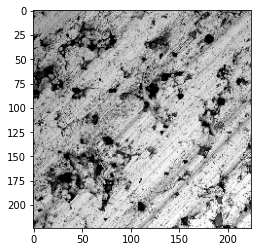

In [9]:
import matplotlib.pyplot as plt  
plt.imshow(X_train[0])

### Build CNN model

In [10]:
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
# from keras.models import Sequential, Model

# model = Sequential()

# # Block_1
# model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=X_train.shape[1:]))
# model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block_2
# model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block_3
# model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block_4
# model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block_5
# model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block_6
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(CLASS_num, activation='softmax'))

# model.summary()

In [11]:
from keras import applications
from keras.layers import Flatten, Dense, Dropout, Activation
from keras.models import Sequential, Model

base_model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])
print(base_model.output)
model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(CLASS_num, activation='softmax'))
model=Model(inputs=base_model.input, outputs=model(base_model.output))

2023-11-20 10:57:53.873596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 10:57:54.611669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:17:00.0, compute capability: 8.9


58889256/58889256 [==============================] - 3s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


### Model compiling&training

In [12]:
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [13]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),                
              loss='binary_crossentropy', 
              metrics=['accuracy',
                       keras.metrics.AUC(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall()])

callbacks = [
             keras.callbacks.ModelCheckpoint(os.path.join(SAVE_path, "best_model.hdf5"),
                                             monitor="val_loss",
                                             mode="min",
                                             verbose = 1,
                                             save_best_only=True),
             # keras.callbacks.EarlyStopping(monitor="val_loss",
             #                               mode="min",
             #                               verbose=1,
             #                               patience=10,
             #                               restore_best_weights=True), 
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2,
                                               patience=2,
                                               min_lr=0.000001),
             # keras.callbacks.TensorBoard(log_dir=os.path.join(SAVE_path, "logs"),
             #                             histogram_freq=1,
             #                             write_graph=True,
             #                             write_images=True),
            ]

history = model.fit(X_train, Y_train,
                    # validation_split=0.2,
                    validation_data=(X_test, Y_test),
                    epochs=100, 
                    batch_size=10, 
                    callbacks=callbacks, 
                    shuffle=True)

Epoch 1/100


2023-11-20 10:58:02.216753: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-11-20 10:58:03.228327: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-20 10:58:03.228363: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-11-20 10:58:03.228476: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-20 10:58:04.231035: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.5576 - auc: 0.5647 - precision: 0.5576 - recall: 0.5576
Epoch 1: val_loss improved from inf to 0.69015, saving model to /root/IDB_3d_printing/outputs/best_model.hdf5
17/17 [==============================] - 8s 143ms/step - loss: 0.7948 - accuracy: 0.5576 - auc: 0.5647 - precision: 0.5576 - recall: 0.5576 - val_loss: 0.6902 - val_accuracy: 0.5000 - val_auc: 0.6366 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5030 - auc: 0.5604 - precision: 0.5030 - recall: 0.5030
Epoch 2: val_loss improved from 0.69015 to 0.63589, saving model to /root/IDB_3d_printing/outputs/best_model.hdf5
17/17 [==============================] - 1s 73ms/step - loss: 0.6874 - accuracy: 0.5030 - auc: 0.5604 - precision: 0.5030 - recall: 0.5030 - val_loss: 0.6359 - val_accuracy: 0.5000 - val_auc: 0.7483 - val_precision: 0.5000 - val_recal

In [14]:
model_path = os.path.join(SAVE_path, "model.hdf5")
model.save(model_path)

### Training curve

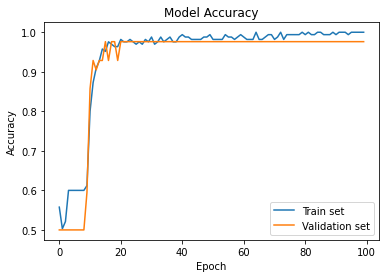

In [15]:
# Plot Accuracy-Epoch_default
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='lower right')
plt.savefig(os.path.join(SAVE_path, 'model_accuracy_default.png'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

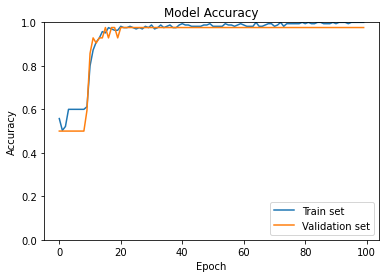

In [16]:
# Plot Accuracy-Epoch 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='lower right')
plt.ylim(0,1)
plt.savefig(os.path.join(SAVE_path, 'model_accuracy.png'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

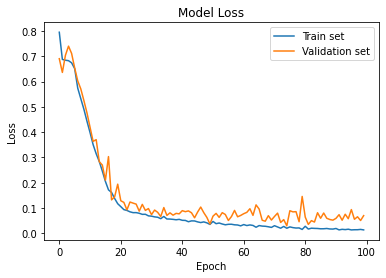

In [17]:
# Plot Loss-Epoch_default
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='upper right')
plt.savefig(os.path.join(SAVE_path, 'model_loss_default.png'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Model predict

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

2/2 [==============================] - 1s 10ms/step
(42, 2)
(42, 2)
[1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1
 1 0 0 0 1]
[1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1
 1 0 0 0 1]


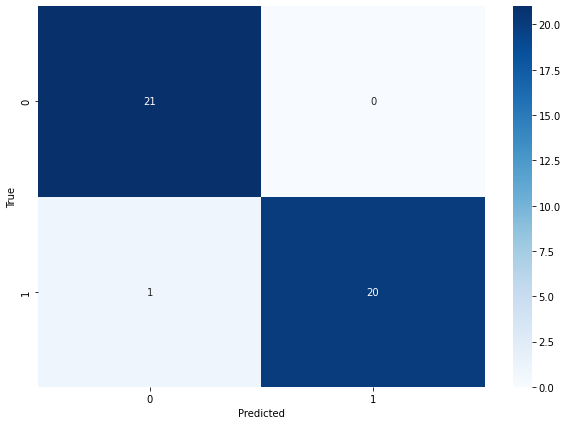

In [19]:
Y_pred = model.predict(X_test)
print(Y_test.shape)
print(Y_pred.shape)

Y_test_true = np.argmax(Y_test, axis=1)  
Y_test_pred = np.argmax(Y_pred, axis=1) 
print(Y_test_true)
print(Y_test_pred)

cm = confusion_matrix(Y_test_true, Y_test_pred)   
plt.figure(figsize=(10,7))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.show()

### Layer visualization

In [20]:
visual_folder = os.path.join(SAVE_path, "classification_model_visual")
visual_plot_folder = os.path.join(SAVE_path, "classification_model_visual_plot")

if not os.path.isdir(visual_folder):
  os.makedirs(visual_folder)

if not os.path.isdir(visual_plot_folder):
  os.makedirs(visual_plot_folder)

In [21]:
# def visual(model, data, num_layer):
#   data = np.expand_dims(data, axis=0) 
#   layer = keras.backend.function([model.layers[0].input], [model.layers[num_layer].output])
#   f1 = layer([data])[0]
#   num = f1.shape[-1]
#   plt.figure(figsize=(8, 8))
#   print("saving images in layer_"+str(num_layer)+" ...")
#   for i in range(num):
#     plt.subplot(np.ceil(np.sqrt(num)), np.ceil(np.sqrt(num)), i+1)
#     layer_img = f1[0, :, :, i] * 255
#     plt.imshow(layer_img, cmap='gray')
#     plt.axis('off')
#     visual_single_name = "layer_"+str(num_layer)+"_img_"+str(i)+".png"
#     layer_single_path = os.path.join(visual_folder, visual_single_name)
#     cv2.imwrite(layer_single_path, layer_img)
#   layer_all_name = "layer_"+str(num_layer)+".png"
#   layer_all_path = os.path.join(visual_plot_folder, layer_all_name)
#   plt.savefig(layer_all_path, dpi=300)
#   plt.show()

In [23]:
import math  
  
def visual(model, data, num_layer):  
  data = np.expand_dims(data, axis=0)   
  layer = keras.backend.function([model.layers[0].input], [model.layers[num_layer].output])  
  f1 = layer([data])[0]  
  num = f1.shape[-1]  
  plt.figure(figsize=(8, 8))  
  print("saving images in layer_"+str(num_layer)+" ...")  
  for i in range(num):  
    plt.subplot(math.ceil(math.sqrt(num)), math.ceil(math.sqrt(num)), i+1)  
    layer_img = f1[0, :, :, i] * 255  
    plt.imshow(layer_img, cmap='gray')  
    plt.axis('off')  
    visual_single_name = "layer_"+str(num_layer)+"_img_"+str(i)+".png"  
    layer_single_path = os.path.join(visual_folder, visual_single_name)  
    cv2.imwrite(layer_single_path, layer_img)  
  layer_all_name = "layer_"+str(num_layer)+".png"  
  layer_all_path = os.path.join(visual_plot_folder, layer_all_name)  
  plt.savefig(layer_all_path, dpi=300)  
  plt.show()  

saving images in layer_0 ...


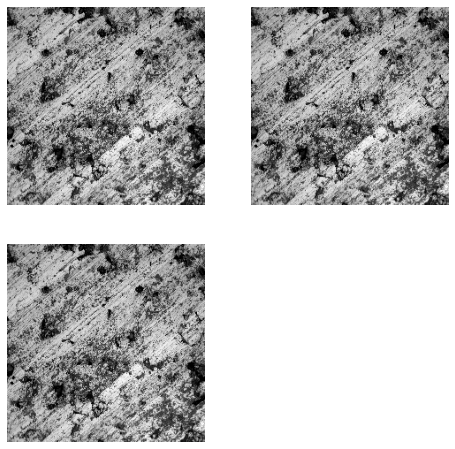

saving images in layer_1 ...


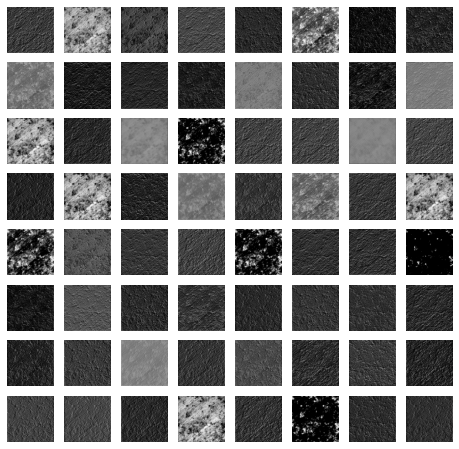

saving images in layer_2 ...


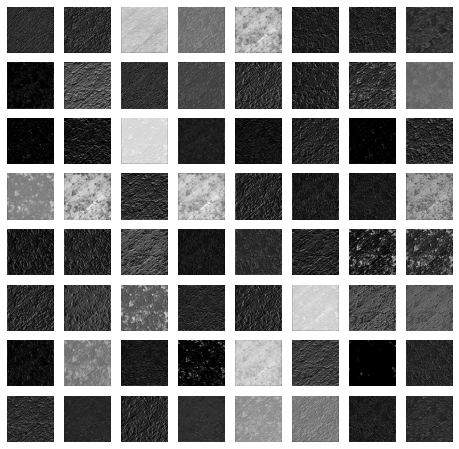

saving images in layer_3 ...


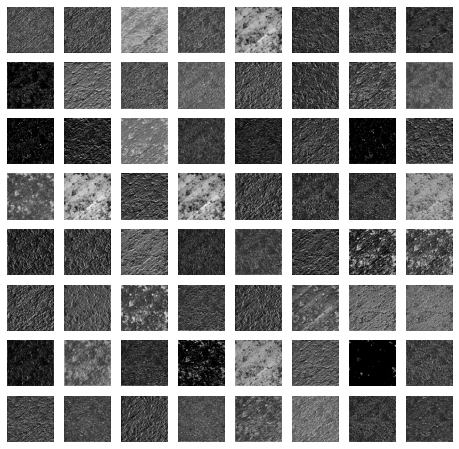

saving images in layer_4 ...


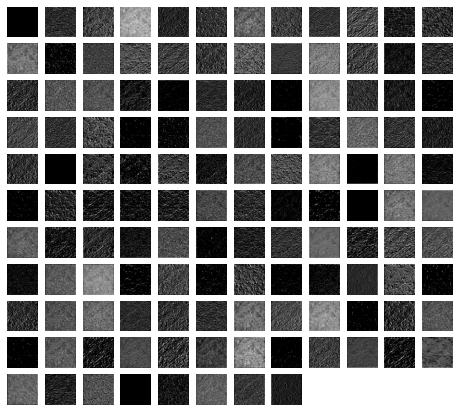

saving images in layer_5 ...


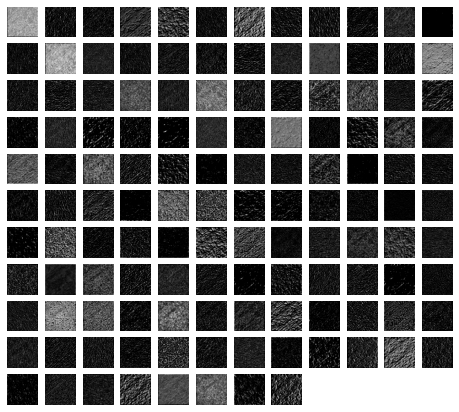

saving images in layer_6 ...


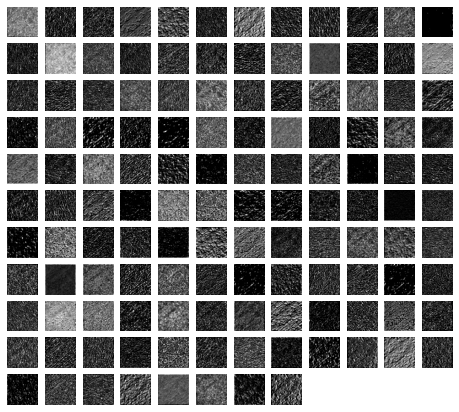

saving images in layer_7 ...


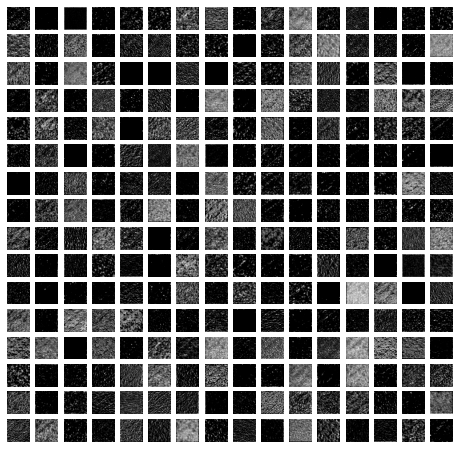

saving images in layer_8 ...


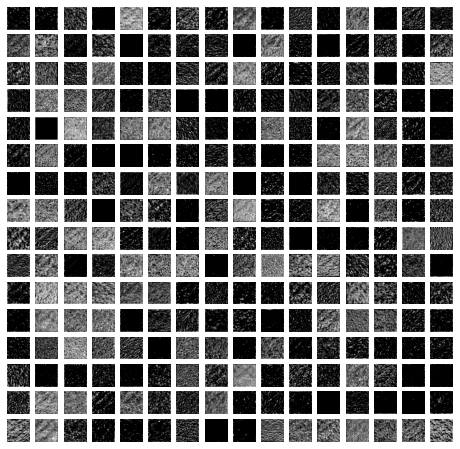

saving images in layer_9 ...


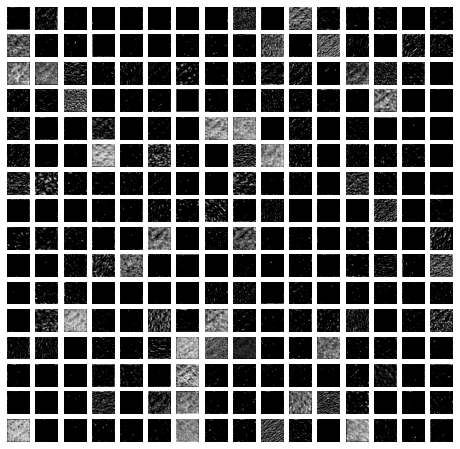

saving images in layer_10 ...


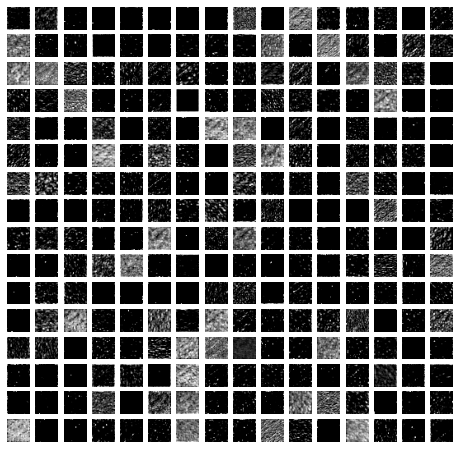

saving images in layer_11 ...


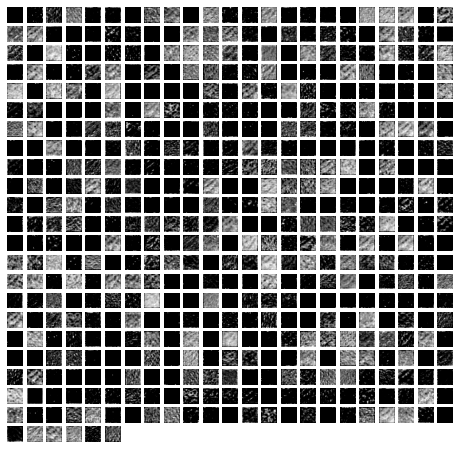

saving images in layer_12 ...


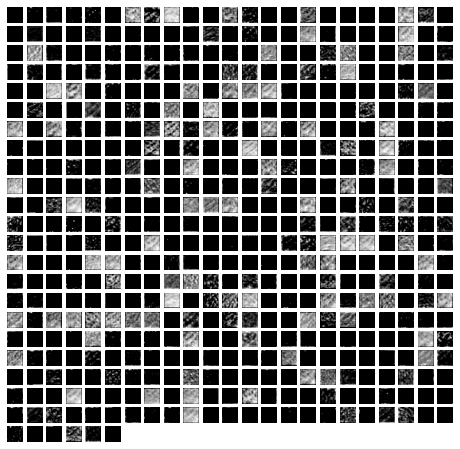

saving images in layer_13 ...


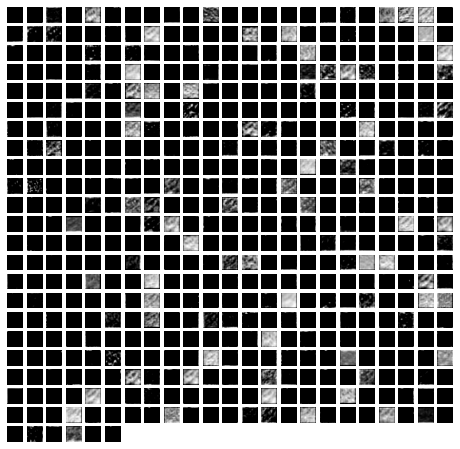

saving images in layer_14 ...


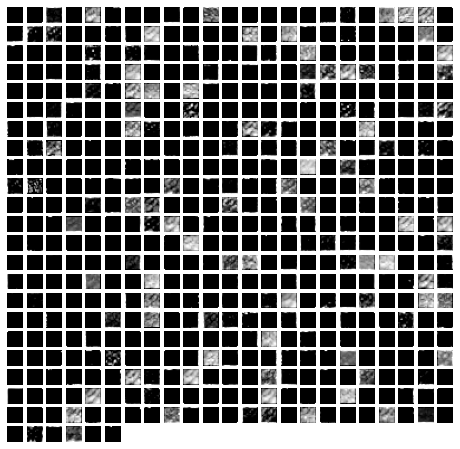

saving images in layer_15 ...


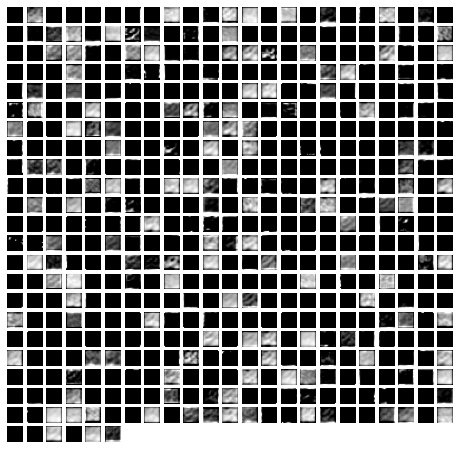

saving images in layer_16 ...


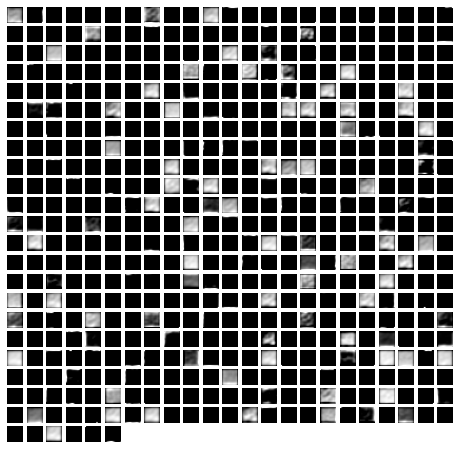

saving images in layer_17 ...


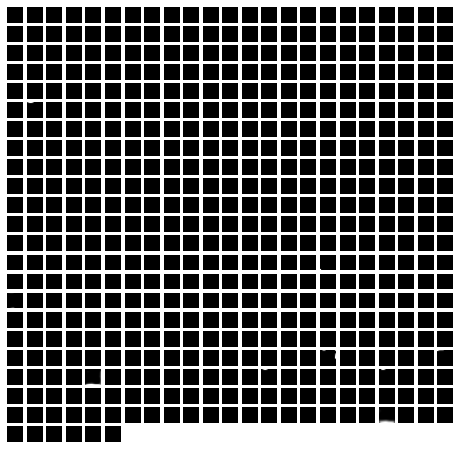

saving images in layer_18 ...


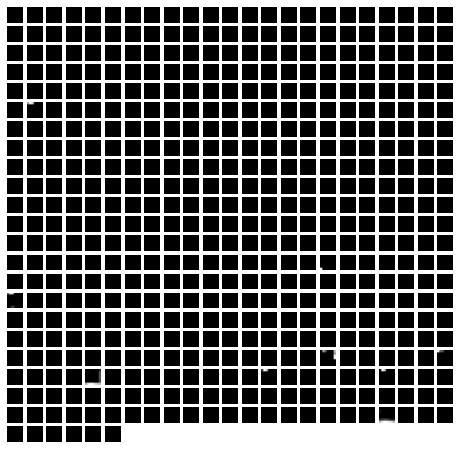

All layer images saved!


In [24]:
for i in range(19): 
  visual(model, X_test[0], i)
print("All layer images saved!")

### Grad CAM

In [25]:
import os
import cv2
import heapq
import keras
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import (VGG16, preprocess_input, decode_predictions)
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework import ops
tf.compat.v1.disable_eager_execution()

In [39]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu
        new_model = load_model(model_path)
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def _compute_gradients(tensor, var_list):
    with tf.GradientTape() as gtape:
        grads = gtape.gradient(tensor, var_list)
        return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

def load_image(path):
    img_path = path
    img = cv2.imread(img_path)
    img = img[0:1024][0:1024]
    img= cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
    x = img
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def doCAM(image_path, image_code, dirs1):
    preprocessed_input = load_image(image_path)
    register_gradient()
    guided_model = modify_backprop(model, 'GuidedBackProp')
    saliency_fn = compile_saliency_function(guided_model)
    saliency = saliency_fn([preprocessed_input, 0])
    gradcam = saliency[0].transpose(1, 2, 3, 0)
    a = np.squeeze(gradcam)
    plt.imshow(deprocess_image(a))
    cv2.imwrite(dirs1+"/Guided_BP_"+image_code+".jpg", deprocess_image(a))
    pred = model.predict(preprocessed_input)
    print(np.argmax(pred))
    # top1_idx, top2_idx, top3_idx= heapq.nlargest(3, range(len(pred[0])), pred[0].take)
    top1_idx, top2_idx = heapq.nlargest(2, range(len(pred[0])), pred[0].take)
    class_output = model.output[:, top1_idx]
    last_conv_layer = model.get_layer("block5_pool")
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([preprocessed_input])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(image_path)
    img = img[0:1024][0:1024]
    img= cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    plt.imshow(heatmap)
    cv2.imwrite(dirs1+"/Heatmap_"+image_code+".jpg", heatmap)
    heatmap2color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    grd_CAM = cv2.addWeighted(img, 0.6, heatmap2color, 0.4, 0)
    plt.imshow(grd_CAM)
    cv2.imwrite(dirs1+"/Grd-CAM_"+image_code+".jpg", grd_CAM)
    heatmap =cv2.imread(dirs1+"/Heatmap_"+image_code+".jpg")
    guided_CAM = saliency[0].transpose(1, 2, 3, 0) * heatmap[..., np.newaxis]
    guided_CAM = deprocess_image(guided_CAM)
    plt.imshow(guided_CAM)
    cv2.imwrite(dirs1+"/Guided-CAM_"+image_code+".jpg", guided_CAM)

In [ ]:
model_path = os.path.join(SAVE_path, "model.hdf5")
model = load_model(model_path)
model.summary()

In [ ]:
model.layers

In [ ]:
def load_image_list(dataset_path):
  img_path_list = []
  category_names = os.listdir(dataset_path)
  category_names.sort()
  print(category_names)
  category_nums = len(category_names)
  images = []
  for category in category_names:
    category_path = os.path.join(dataset_path, category)
    file_names = os.listdir(category_path)
    file_names.sort()
    print(file_names)
    file_nums = len(file_names)  
    for file in (file_names):
      img_path = os.path.join(category_path, file)
      img_path_list.append(img_path)
  return img_path_list
 
image_path_list = load_image_list(os.path.join(PROJECT_path, "datasets/IMAGE"))

In [ ]:
cam_folder = os.path.join(SAVE_path, "classification_cam_visual")

if not os.path.exists(cam_folder):
    os.makedirs(cam_folder)

In [ ]:
for n in range(0,len(image_path_list)):
    print("> "+str(n)+str(image_path_list[n]))
    image_path = image_path_list[n]
    image_code = str(n)
    doCAM(image_path, image_code, cam_folder)